
# Unified Silhouette Pipeline (HDR Coverage + Point-Fraction)

This notebook unifies both pipelines into one workflow with shared preprocessing, shared grid utilities, a common **ShapeProduct** interface, and a single metrics/plotting stack.  
You can toggle which variants to run and export figures/metrics side-by-side.

**Variants**
- `hdr` — *coverage mass on a float density field* (bootstrapped & smoothed) → mass-threshold isocontour.
- `point_fraction` — *densest subset of points (top p% by KDE)* → rasterized binary mask → contour.

> Semantics are preserved (mass vs densest-subset). Downstream metrics/plots are shared.


Wrote: data/green_monkey/va_testing/out_unified_step1/metrics_unified.csv


,plane,level,variant,IoU,meanNN,Hausdorff
22,XY,100,hdr,0.750930,5.081812,23.236215
23,XY,99,hdr,0.634577,5.255348,23.170830
24,XY,98,hdr,0.591358,5.758198,22.632893
25,XY,97,hdr,0.561441,5.111475,17.845996
26,XY,96,hdr,0.534387,5.420998,19.098822
27,XY,95,hdr,0.512989,5.262549,20.272934
28,XY,90,hdr,0.446524,5.073710,25.015234
29,XY,80,hdr,0.359690,6.463194,33.117883
30,XY,60,hdr,0.231888,3.122064,15.582034
31,XY,50,hdr,0.195914,6.132452,23.355832


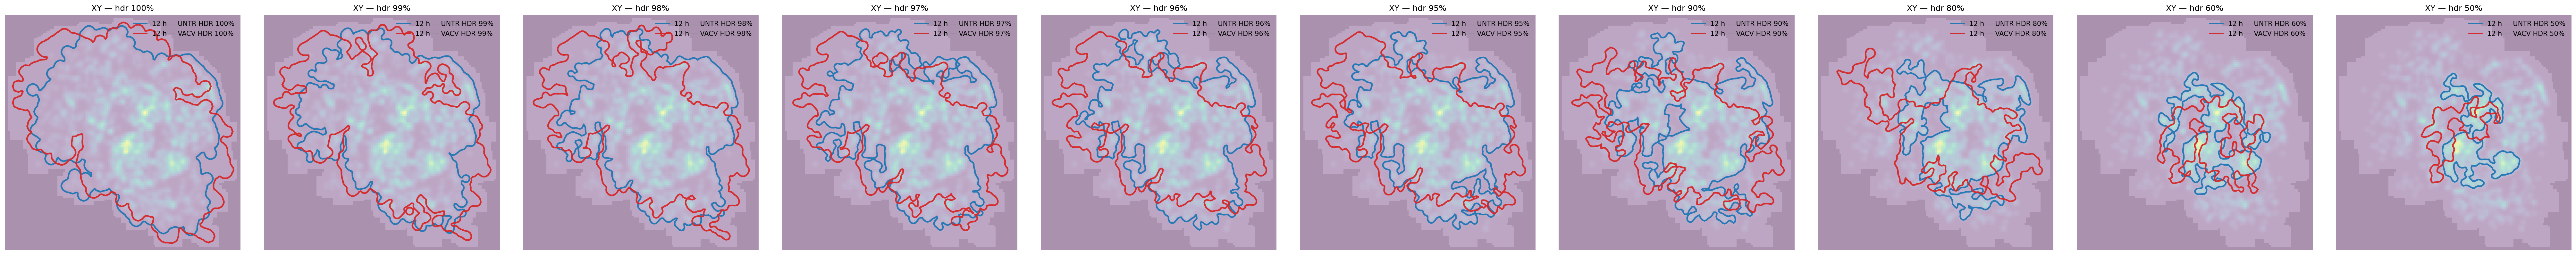

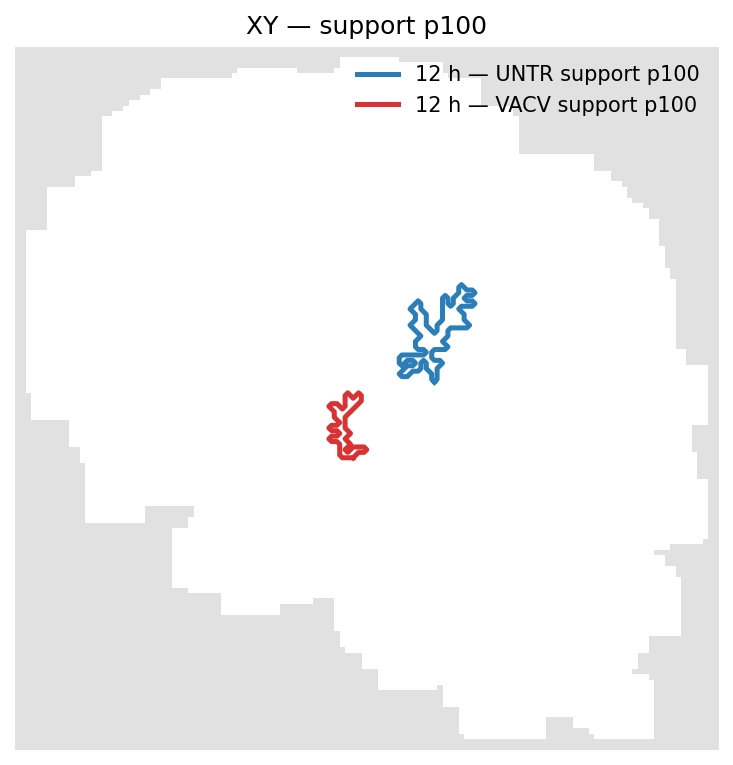

In [9]:
# ========================== STEP 1: UNIFIED PIPELINE (HDR + POINT-FRACTION) ==========================
# Toggle these to run one or both pipelines:
RUN_HDR = True
RUN_PF  = True

# ----------- Configs / Paths -----------
import os, json, math, itertools, glob
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional, TypedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening, binary_fill_holes
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

np.set_printoptions(suppress=True)
plt.rcParams['figure.dpi'] = 150

@dataclass
class CfgCommon:
    grid_base: int = 160
    pad_frac: float = 0.05
    trim_q: float = 0.10
    icp_iters: int = 30
    sample_icp: int = 50000
    out_dir: str = "out_unified_step1"

@dataclass
class CfgHDR:
    n_boot: int = 256
    sample_frac: float = 1.0
    sigma_px: float = 1.2
    density_floor_frac: float = 0.002
    mass_levels: Tuple[float, ...] = (1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50)
    use_support_p100: bool = True
    support_min_hits: int = 1

@dataclass
class CfgPF:
    frac_levels: Tuple[float, ...] = (1.00, 0.95, 0.90, 0.80, 0.60, 0.50)
    bandwidth: Optional[float] = None
    disk_px: int = 2

# EDIT THESE
LABEL_A = "12 h — UNTR"
LABEL_B = "12 h — VACV"
CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"

CFG_COMMON = CfgCommon(out_dir="data/green_monkey/va_testing/out_unified_step1")
CFG_HDR    = CfgHDR()
CFG_PF     = CfgPF()
os.makedirs(CFG_COMMON.out_dir, exist_ok=True)

# ----------- Utilities -----------
def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1)
    return float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))

def best_pca_prealign(B_pts, A_pts):
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

PLANE_FROM_AXIS = {'z': 'XY', 'x': 'YZ', 'y': 'XZ'}
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}

def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    mn, mx = P.min(0), P.max(0)
    ext = mx - mn
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    scale = base / float(ext.max() + 1e-8)
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

def grid_centers_from_edges(ex, ey):
    nx = len(ex) - 1; ny = len(ey) - 1
    xs = np.linspace(ex[0], ex[-1], nx)
    ys = np.linspace(ey[0], ey[-1], ny)
    return xs, ys

def save_point_projection_like_screenshot(A, B, i, j, plane, out_dir, labelA="A", labelB="B"):
    all2 = np.vstack([A[:,[i,j]], B[:,[i,j]]])
    (xmin,ymin) = all2.min(0); (xmax,ymax) = all2.max(0)
    xr, yr = (xmax-xmin), (ymax-ymin); pad = 0.02
    fig, ax = plt.subplots(figsize=(5,4))
    ax.set_facecolor("#f0f0f0")
    ax.scatter(A[:, i], A[:, j], marker="+", s=8, linewidths=0.6, alpha=0.85, c="#1f77b4", label=labelA)
    ax.scatter(B[:, i], B[:, j], marker="x", s=8, linewidths=0.6, alpha=0.75, c="#d62728", label=labelB)
    ax.set_xlim(xmin - pad*xr, xmax + pad*xr); ax.set_ylim(ymin - pad*yr, ymax + pad*yr)
    ax.set_aspect("equal","box"); ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(plane); ax.legend(loc="upper left", fontsize=8, frameon=True)
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"proj_{plane}.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

# ----------- Shared result type -----------
class ShapeProduct(TypedDict):
    plane: str
    level: int
    variant: str
    mask: np.ndarray
    contour: Optional[np.ndarray]

# ----------- HDR functions -----------
def apply_density_floor(D: np.ndarray, frac: float) -> np.ndarray:
    if frac <= 0: return D
    eps = float(frac) * float(D.max() if np.isfinite(D.max()) else 0.0)
    if eps <= 0: return D
    Df = D.copy(); Df[Df < eps] = 0.0
    return Df

def mass_threshold(D: np.ndarray, mass: float) -> float:
    flat = D.ravel(); s = flat.sum()
    if s <= 0: return float('inf')
    if mass >= 0.999999:
        pos = flat[flat > 0]
        return float(pos.min()) if pos.size else float('inf')
    v = np.sort(flat)[::-1]; c = np.cumsum(v)
    return float(v[np.searchsorted(c, mass * c[-1], side='left')])

def contour_at_mass(D: np.ndarray, mass: float) -> Optional[np.ndarray]:
    tau = mass_threshold(D, mass)
    if not np.isfinite(tau): return None
    cs = find_contours(D, level=tau)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

def boot_density_and_support_2d(P: np.ndarray, edges3d, n_boot=256, sample_frac=1.0, sigma_px=1.2, support_min_hits=1):
    xed, yed, zed = edges3d
    plane_edges = {'z': (xed, yed), 'x': (yed, zed), 'y': (xed, zed)}
    accD = {a: None for a in ('x','y','z')}
    accC = {a: None for a in ('x','y','z')}
    n = len(P); k = max(1, int(round(sample_frac * n)))
    rs = np.random.default_rng(0)
    for _ in range(n_boot):
        idx = rs.integers(0, n, size=k); sub = P[idx]
        for a in ('x','y','z'):
            i, j = AXPAIR[a]; ex, ey = plane_edges[a]
            H, _, _ = np.histogram2d(sub[:, i], sub[:, j], bins=[ex, ey])
            D = gaussian_filter(H.astype(np.float32), sigma=sigma_px).T
            if accD[a] is None: accD[a] = D
            else: accD[a] += D
            S = (H > 0).T
            if accC[a] is None: accC[a] = S.astype(np.uint16)
            else: accC[a] += S.astype(np.uint16)
    outD = {a: (accD[a] / float(n_boot)) if accD[a] is not None else None for a in accD}
    outS = {a: (accC[a] >= support_min_hits) if accC[a] is not None else None for a in accC}
    return outD, outS

def make_hdr_shape(D: np.ndarray, plane: str, mass: float, density_floor_frac: float) -> ShapeProduct:
    Df = apply_density_floor(D, density_floor_frac)
    tau = mass_threshold(Df, mass)
    mask = (Df >= tau)
    contour = contour_at_mass(Df, mass)
    return dict(plane=plane, level=int(round(mass*100)), variant="hdr", mask=mask, contour=contour)

# ----------- Point-Fraction functions -----------
def kde_scores(points2d: np.ndarray, bandwidth: float) -> np.ndarray:
    if points2d.shape[0] < 2:
        return np.zeros(points2d.shape[0])
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points2d)
    return kde.score_samples(points2d)

def auto_bandwidth(points2d: np.ndarray) -> float:
    N = points2d.shape[0]
    if N <= 1: return 1.0
    if N > 500:
        idx = np.random.choice(N, size=500, replace=False); samp = points2d[idx]
    else:
        samp = points2d
    md = np.median(pdist(samp)) if samp.shape[0] >= 2 else 1.0
    return max(1e-6, md * 0.5)

def rasterize_points(points2d: np.ndarray, xs, ys, disk_px=2) -> np.ndarray:
    ny, nx = len(ys), len(xs)
    img = np.zeros((ny, nx), dtype=bool)
    rr = np.arange(-disk_px, disk_px+1)
    XX, YY = np.meshgrid(rr, rr, indexing='xy')
    disk = (XX**2 + YY**2) <= (disk_px**2)
    dh, dw = disk.shape[0]//2, disk.shape[1]//2
    x_idx = np.clip(np.searchsorted(xs, points2d[:,0]) - 1, 0, nx-1)
    y_idx = np.clip(np.searchsorted(ys, points2d[:,1]) - 1, 0, ny-1)
    for y, x in zip(y_idx, x_idx):
        y0, y1 = max(0, y-dh), min(ny, y+dh+1)
        x0, x1 = max(0, x-dw), min(nx, x+dw+1)
        dy0 = 0 if y0==y-dh else (y-dh - y0)
        dx0 = 0 if x0==x-dw else (x-dw - x0)
        img[y0:y1, x0:x1] |= disk[dy0:dy0+(y1-y0), dx0:dx0+(x1-x0)]
    return img

def biggest_component_mask(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0: return mask
    from scipy.ndimage import label as _label
    labeled_mask, num_features = _label(mask)
    if num_features == 0: return mask
    component_sizes = np.bincount(labeled_mask.ravel())
    if len(component_sizes) <= 1: return np.zeros_like(mask)
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    largest_component = (labeled_mask == largest_component_label)
    solid_mask = binary_fill_holes(largest_component)
    return solid_mask

def point_fraction_mask(points2d: np.ndarray, xs, ys, frac: float, bandwidth: Optional[float], disk_px: int):
    N = points2d.shape[0]
    k = max(1, int(math.ceil(frac * N)))
    bw = auto_bandwidth(points2d) if bandwidth is None else bandwidth
    scores = kde_scores(points2d, bandwidth=bw)
    order = np.argsort(scores)[::-1]
    kept = points2d[order[:k]]
    mask = rasterize_points(kept, xs, ys, disk_px=disk_px)
    mask = binary_closing(mask, iterations=1)
    mask = binary_opening(mask, iterations=1)
    mask = biggest_component_mask(mask)
    return mask, kept, bw

def make_pf_shape(points2d: np.ndarray, xs, ys, plane: str, frac: float, bandwidth: Optional[float], disk_px: int) -> ShapeProduct:
    mask, kept, bw = point_fraction_mask(points2d, xs, ys, frac, bandwidth, disk_px)
    cs = find_contours(mask.astype(float), 0.5)
    cs.sort(key=lambda c: c.shape[0], reverse=True) if cs else None
    contour = cs[0] if cs else None
    return dict(plane=plane, level=int(round(frac*100)), variant="point_fraction", mask=mask, contour=contour)

# ----------- Metrics / Overlay -----------
def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]):
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

def save_overlay(shapeA: ShapeProduct, shapeB: ShapeProduct, background_mask: Optional[np.ndarray], out_dir: str, labelA: str, labelB: str):
    plane = shapeA['plane']; variant = shapeA['variant']; level = shapeA['level']
    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    if background_mask is not None:
        ax.imshow(background_mask, cmap="gray", alpha=0.12)
    if shapeA['contour'] is not None:
        ax.plot(shapeA['contour'][:,1], shapeA['contour'][:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95, label=f"{labelA} {variant} {level}%")
    if shapeB['contour'] is not None:
        ax.plot(shapeB['contour'][:,1], shapeB['contour'][:,0], '-', lw=2.4, color="#d62728", alpha=0.95, label=f"{labelB} {variant} {level}%")
    ax.set_title(f"{plane} — {variant} {level}%"); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"overlay_{plane}_p{level}_{variant}.png"), dpi=220, bbox_inches="tight")
    plt.close(fig)

# ====================================================================================================
# ================================ RUN (preprocessing → branches) ====================================
# ====================================================================================================
# 1) Load & center
A_raw, B_raw = load_points(CSV_A), load_points(CSV_B)
A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)

# 2) Align B->A (PCA prealign + robust ICP)
Rpre = best_pca_prealign(B0, A0)
B1 = B0 @ Rpre.T
Ricp, ticp = icp_rigid_robust(A0, B1, iters=CFG_COMMON.icp_iters, sample=CFG_COMMON.sample_icp, trim_q=CFG_COMMON.trim_q)
A_al, B_al = A0, (B1 @ Ricp.T + ticp)

# 3) Uniform scale (shared bbox)
mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
s = float((maxs - mins).max())
A = A_al/s; B = B_al/s

# 4) Shared 3D grid
edges3d, _ = make_grid_from_bounds(np.vstack([A, B]), base=CFG_COMMON.grid_base, pad_frac=CFG_COMMON.pad_frac)

# 5) Save point projections (context)
save_point_projection_like_screenshot(A, B, 0, 1, "XY", CFG_COMMON.out_dir, LABEL_A, LABEL_B)
save_point_projection_like_screenshot(A, B, 1, 2, "YZ", CFG_COMMON.out_dir, LABEL_A, LABEL_B)
save_point_projection_like_screenshot(A, B, 0, 2, "XZ", CFG_COMMON.out_dir, LABEL_A, LABEL_B)

# Background mask for each plane
background_per_plane = {}
A2d = {}; B2d = {}; XS = {}; YS = {}
for a in ('x','y','z'):
    plane = PLANE_FROM_AXIS[a]
    i, j = AXPAIR[a]
    ex, ey = edges3d[i], edges3d[j]
    xs, ys = grid_centers_from_edges(ex, ey)
    XS[plane], YS[plane] = xs, ys
    A2, B2 = A[:, [i, j]], B[:, [i, j]]
    A2d[plane], B2d[plane] = A2, B2
    # faint background mask = union of all rasterized points
    bg = np.logical_or(rasterize_points(A2, xs, ys, disk_px=2),
                       rasterize_points(B2, xs, ys, disk_px=2))
    background_per_plane[plane] = bg

# ---------------- HDR branch ----------------
DensA = {}; DensB = {}; SuppA = {}; SuppB = {}
if RUN_HDR:
    DA_dict, SA_dict = boot_density_and_support_2d(A, edges3d,
        n_boot=CFG_HDR.n_boot, sample_frac=CFG_HDR.sample_frac,
        sigma_px=CFG_HDR.sigma_px, support_min_hits=CFG_HDR.support_min_hits)
    DB_dict, SB_dict = boot_density_and_support_2d(B, edges3d,
        n_boot=CFG_HDR.n_boot, sample_frac=CFG_HDR.sample_frac,
        sigma_px=CFG_HDR.sigma_px, support_min_hits=CFG_HDR.support_min_hits)
    DensA.update(DA_dict); SuppA.update(SA_dict)
    DensB.update(DB_dict); SuppB.update(SB_dict)
    # save densities
    for a in ('x','y','z'):
        plane = PLANE_FROM_AXIS[a]
        if DensA.get(a) is None or DensB.get(a) is None: continue
        np.save(os.path.join(CFG_COMMON.out_dir, f"density_A_{plane}.npy"), DensA[a])
        np.save(os.path.join(CFG_COMMON.out_dir, f"density_B_{plane}.npy"), DensB[a])

# ---------------- PF branch ----------------
# (no precomputation needed beyond A2d/B2d/xs/ys)

# ---------------- Metrics & overlays ----------------
rows = []
def append_metrics(plane, level, variant, MA, MB, CA, CB):
    IoU = iou_bool(MA, MB)
    mnn, haus = contour_distances(CA, CB)
    rows.append(dict(plane=plane, level=level, variant=variant, IoU=IoU, meanNN=mnn, Hausdorff=haus))

# HDR levels
if RUN_HDR:
    for a in ('x','y','z'):
        plane = PLANE_FROM_AXIS[a]
        D_A, D_B = DensA.get(a), DensB.get(a)
        if D_A is None or D_B is None: continue
        for m in CFG_HDR.mass_levels:
            spA = make_hdr_shape(D_A, plane, m, CFG_HDR.density_floor_frac)
            spB = make_hdr_shape(D_B, plane, m, CFG_HDR.density_floor_frac)
            save_overlay(spA, spB, background_per_plane.get(plane), CFG_COMMON.out_dir, LABEL_A, LABEL_B)
            append_metrics(plane, spA['level'], spA['variant'], spA['mask'], spB['mask'], spA['contour'], spB['contour'])
        if CFG_HDR.use_support_p100 and (SuppA.get(a) is not None) and (SuppB.get(a) is not None):
            CA_s = find_contours(SuppA[a].astype(float), 0.5)
            CB_s = find_contours(SuppB[a].astype(float), 0.5)
            CA_s.sort(key=lambda c: c.shape[0], reverse=True) if CA_s else None
            CB_s.sort(key=lambda c: c.shape[0], reverse=True) if CB_s else None
            spA = dict(plane=plane, level=100, variant="support", mask=SuppA[a], contour=(CA_s[0] if CA_s else None))
            spB = dict(plane=plane, level=100, variant="support", mask=SuppB[a], contour=(CB_s[0] if CB_s else None))
            save_overlay(spA, spB, background_per_plane.get(plane), CFG_COMMON.out_dir, LABEL_A, LABEL_B)
            append_metrics(plane, 100, "support", spA['mask'], spB['mask'], spA['contour'], spB['contour'])

# Point-Fraction levels
if RUN_PF:
    for plane in ('XY','YZ','XZ'):
        xs, ys = XS[plane], YS[plane]
        A2, B2 = A2d[plane], B2d[plane]
        for frac in CFG_PF.frac_levels:
            spA = make_pf_shape(A2, xs, ys, plane, frac, CFG_PF.bandwidth, CFG_PF.disk_px)
            spB = make_pf_shape(B2, xs, ys, plane, frac, CFG_PF.bandwidth, CFG_PF.disk_px)
            save_overlay(spA, spB, background_per_plane.get(plane), CFG_COMMON.out_dir, LABEL_A, LABEL_B)
            append_metrics(plane, spA['level'], spA['variant'], spA['mask'], spB['mask'], spA['contour'], spB['contour'])

# Write metrics + meta
df = pd.DataFrame(rows).sort_values(["plane","variant","level"], ascending=[True, True, False])
df_path = os.path.join(CFG_COMMON.out_dir, "metrics_unified.csv"); df.to_csv(df_path, index=False)
meta = dict(csv_A=CSV_A, csv_B=CSV_B, label_A=LABEL_A, label_B=LABEL_B,
            cfg_common=CFG_COMMON.__dict__, cfg_hdr=CFG_HDR.__dict__, cfg_pf=CFG_PF.__dict__,
            note="Step 1 unified pipeline; HDR=mass on float field; PF=densest-subset mask.")
with open(os.path.join(CFG_COMMON.out_dir, "meta_unified.json"), "w") as f: json.dump(meta, f, indent=2)
print("Wrote:", df_path); display(df.head(12))

# ====================================================================================================
# ===================================== VISUALIZATION HELPERS ========================================
# ====================================================================================================
def _title(plane, variant, level): return f"{plane} — {variant} {level}%"
def _imshow_bg(ax, bg): 
    if bg is not None: ax.imshow(bg, cmap="gray", alpha=0.12)
def _plot_contour(ax, C, color, label):
    if C is not None: ax.plot(C[:,1], C[:,0], '-', lw=2.4, color=color, alpha=0.95, label=label)

def show_hdr(plane="XY", levels=(80, 60, 50), show_support=True, show_heat=True):
    rev = {"XY":"z","YZ":"x","XZ":"y"}; akey = rev[plane]
    D_A = DensA.get(akey); D_B = DensB.get(akey)
    if D_A is None or D_B is None:
        print(f"[HDR] No density for {plane} (did you set RUN_HDR=True?)"); return
    D_sum = (D_A>0) | (D_B>0)
    fig, axes = plt.subplots(1, len(levels), figsize=(5.4*len(levels), 5.2))
    axes = [axes] if not isinstance(axes, (list, np.ndarray)) else axes
    for ax, p in zip(axes, levels):
        spA = make_hdr_shape(D_A, plane, p/100.0, CFG_HDR.density_floor_frac)
        spB = make_hdr_shape(D_B, plane, p/100.0, CFG_HDR.density_floor_frac)
        ax.imshow(D_sum, cmap="gray", alpha=0.12)
        if show_heat: ax.imshow(D_A, alpha=0.35)
        _plot_contour(ax, spA['contour'], "#1f77b4", f"{LABEL_A} HDR {p}%")
        _plot_contour(ax, spB['contour'], "#d62728", f"{LABEL_B} HDR {p}%")
        ax.set_title(_title(plane, "hdr", p)); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    plt.tight_layout(); plt.show()
    if show_support and (SuppA.get(akey) is not None) and (SuppB.get(akey) is not None):
        SA, SB = SuppA[akey], SuppB[akey]
        CA = find_contours(SA.astype(float), 0.5); CB = find_contours(SB.astype(float), 0.5)
        CA.sort(key=lambda c: c.shape[0], reverse=True) if CA else None
        CB.sort(key=lambda c: c.shape[0], reverse=True) if CB else None
        fig, ax = plt.subplots(figsize=(5.4, 5.2))
        _imshow_bg(ax, D_sum)
        _plot_contour(ax, (CA[0] if CA else None), "#1f77b4", f"{LABEL_A} support p100")
        _plot_contour(ax, (CB[0] if CB else None), "#d62728", f"{LABEL_B} support p100")
        ax.set_title(f"{plane} — support p100"); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
        plt.tight_layout(); plt.show()

def show_point_fraction(plane="XY", levels=(100, 95, 80), scatter_faint=True):
    if plane not in A2d:
        print("[PF] Missing plane prep (did you run the pipeline?)"); return
    xs, ys = XS[plane], YS[plane]; A2, B2 = A2d[plane], B2d[plane]
    bg = background_per_plane.get(plane)
    fig, axes = plt.subplots(1, len(levels), figsize=(5.4*len(levels), 5.2))
    axes = [axes] if not isinstance(axes, (list, np.ndarray)) else axes
    for ax, p in zip(axes, levels):
        spA = make_pf_shape(A2, xs, ys, plane, p/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
        spB = make_pf_shape(B2, xs, ys, plane, p/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
        _imshow_bg(ax, bg)
        if scatter_faint:
            ax.scatter(A2[:,0], A2[:,1], s=2, alpha=0.15, c="#1f77b4")
            ax.scatter(B2[:,0], B2[:,1], s=2, alpha=0.15, c="#d62728")
        _plot_contour(ax, spA['contour'], "#1f77b4", f"{LABEL_A} point {p}%")
        _plot_contour(ax, spB['contour'], "#d62728", f"{LABEL_B} point {p}%")
        ax.set_title(_title(plane, "point_fraction", p)); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    plt.tight_layout(); plt.show()

def compare_at(plane="XY", variant="hdr", level=80):
    fig, ax = plt.subplots(figsize=(5.6,5.2))
    _imshow_bg(ax, background_per_plane.get(plane))
    if variant == "hdr":
        rev = {"XY":"z","YZ":"x","XZ":"y"}; akey = rev[plane]
        D_A, D_B = DensA.get(akey), DensB.get(akey)
        if D_A is None or D_B is None:
            print("[HDR] No density available"); return
        spA = make_hdr_shape(D_A, plane, level/100.0, CFG_HDR.density_floor_frac)
        spB = make_hdr_shape(D_B, plane, level/100.0, CFG_HDR.density_floor_frac)
    elif variant == "point_fraction":
        xs, ys = XS[plane], YS[plane]; A2, B2 = A2d[plane], B2d[plane]
        spA = make_pf_shape(A2, xs, ys, plane, level/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
        spB = make_pf_shape(B2, xs, ys, plane, level/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
    else:  # support
        rev = {"XY":"z","YZ":"x","XZ":"y"}; akey = rev[plane]
        SA, SB = SuppA.get(akey), SuppB.get(akey)
        CA = find_contours(SA.astype(float), 0.5) if SA is not None else []
        CB = find_contours(SB.astype(float), 0.5) if SB is not None else []
        CA.sort(key=lambda c: c.shape[0], reverse=True) if CA else None
        CB.sort(key=lambda c: c.shape[0], reverse=True) if CB else None
        spA = dict(plane=plane, level=100, variant="support", mask=(SA if SA is not None else np.zeros_like(background_per_plane.get(plane), dtype=bool)), contour=(CA[0] if CA else None))
        spB = dict(plane=plane, level=100, variant="support", mask=(SB if SB is not None else np.zeros_like(background_per_plane.get(plane), dtype=bool)), contour=(CB[0] if CB else None))
    _plot_contour(ax, spA['contour'], "#1f77b4", f"{LABEL_A} {variant} {level}%")
    _plot_contour(ax, spB['contour'], "#d62728", f"{LABEL_B} {variant} {level}%")
    ax.set_title(_title(plane, variant, level)); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    plt.tight_layout(); plt.show()

# ============================== ONE-LINER VIEW WRAPPER ==============================
def _levels_to_ints(levels):
    if isinstance(levels, (list, tuple, set, np.ndarray)):
        return tuple(int(x) for x in levels)
    if isinstance(levels, str) and levels.lower() == "all":
        return "all"
    if isinstance(levels, (int, float)):
        return (int(levels),)
    raise ValueError("levels must be an int, list/tuple of ints, or 'all'")

def _resolve_levels(kind, levels):
    L = _levels_to_ints(levels)
    if L != "all":
        return L
    if kind == "hdr":
        return tuple(sorted({int(round(p*100)) for p in CFG_HDR.mass_levels}, reverse=True))
    if kind == "point_fraction":
        return tuple(sorted({int(round(p*100)) for p in CFG_PF.frac_levels}, reverse=True))
    if kind == "support":
        return (100,)
    raise ValueError(f"Unknown kind: {kind}")

def view(kind="hdr", plane="XY", levels="all", **opts):
    """
    kind: 'hdr' | 'point_fraction' | 'support'
    plane: 'XY' | 'YZ' | 'XZ'
    levels: int | sequence[int] | 'all'
    opts:
      - For hdr: show_support=True/False, show_heat=True/False
      - For point_fraction: scatter_faint=True/False
    """
    kind = str(kind).lower()
    lvls = _resolve_levels(kind, levels)

    if kind == "hdr":
        if not RUN_HDR:
            print("[view] RUN_HDR=False; HDR results not computed.")
            return
        show_hdr(
            plane=plane,
            levels=lvls,
            show_support=opts.get("show_support", True),
            show_heat=opts.get("show_heat", True),
        )
        return

    if kind == "point_fraction":
        if not RUN_PF:
            print("[view] RUN_PF=False; point-fraction results not computed.")
            return
        show_point_fraction(
            plane=plane,
            levels=lvls,
            scatter_faint=opts.get("scatter_faint", True),
        )
        return

    if kind == "support":
        # support is single-level (100%)
        compare_at(plane=plane, variant="support", level=100)
        return

    raise ValueError("kind must be 'hdr', 'point_fraction', or 'support'")

# ----------------------------- examples --------------------------------
view("hdr", plane="XY", levels="all")
# view("point_fraction", plane="XY", levels=[100,95,80])
# view("support", plane="XY")



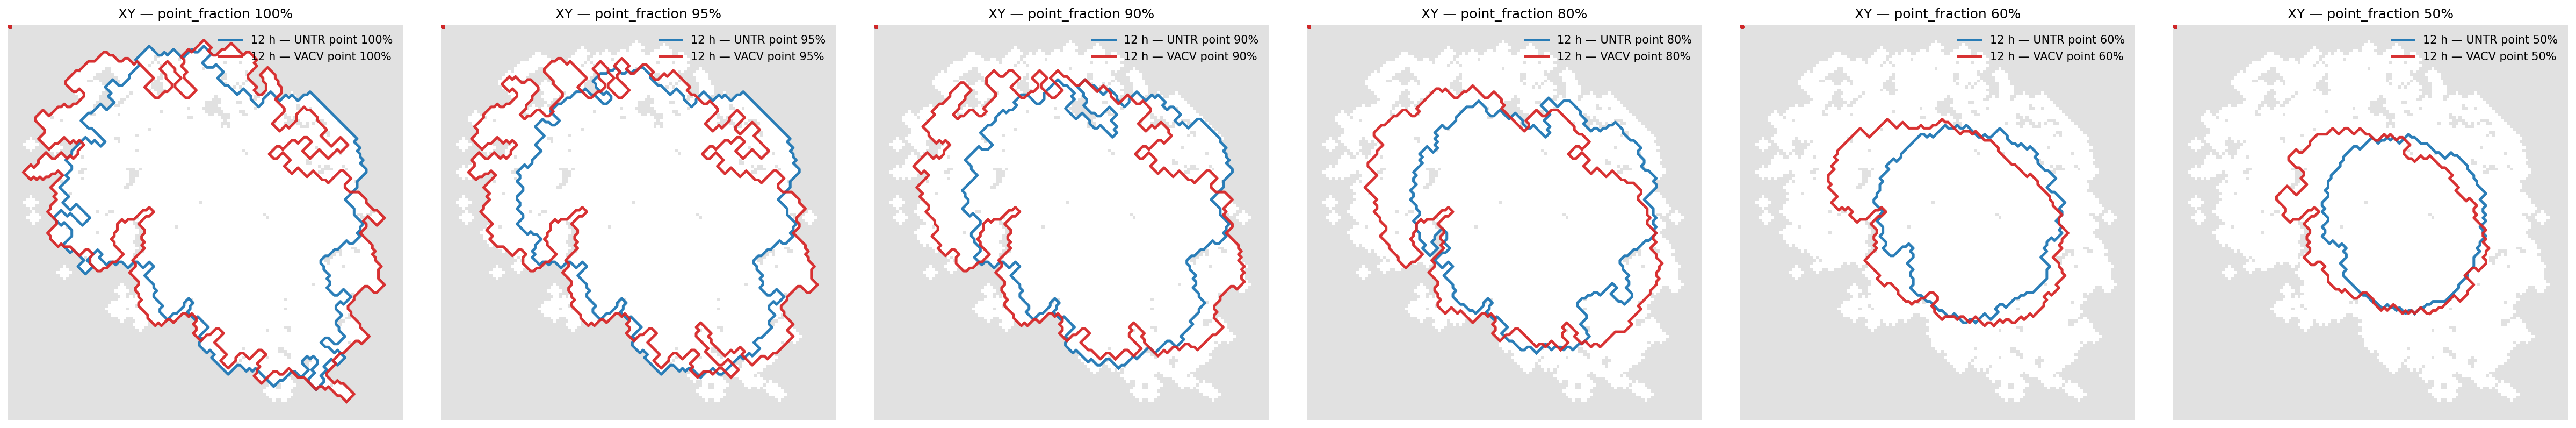

In [10]:
view("point_fraction", plane="XY", levels="all")